In [1]:
# Libraries
import gym
import numpy as np
from collections import deque
from tqdm import tqdm

# Agents
from CarRacingAgents import CarRacingAgent03

# Plots
from CarRacingPlots import plot_performance

c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWarning: HAMMING is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.HAMMING instead.
  'hamming': pil_image.HAMMING,
c:\ProgramData\Anaconda3\envs\tf\lib\site

# Set Experiment - Car Racing
Set the experiment for Car Racing Environment

In [4]:
# Run experiment
def run_experiment(
    environment,
    agent,
    render = False,
    num_episodes = 400,
    skip_frames = 2,
    training_batch_size = 64,
    save_training_frequency = 50,
    update_target_model_frequency = 5,
    model = None, # Use pretrained model
):

    # Load model
    if model:
        agent.load(model)

    for episode in tqdm(range(1, num_episodes+1)):
        
        # Reset Environment
        init_state = environment.reset()

        # Process State
        init_state = agent.process_state_image(init_state, env)

        total_reward = 0
        negative_reward_counter = 0
        state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
        time_frame_counter = 1
        done = False
        
        while True:
            if render:
                env.render()

            current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
            action = agent.act(current_state_frame_stack)

            reward = 0
            for _ in range(skip_frames+1):
                next_state, r, done, _ = env.step(action)
                reward += r
                if done:
                    break

            # If continually getting negative reward 10 times after the tolerance steps, terminate this episode
            negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

            total_reward += reward

            next_state = agent.process_state_image(next_state, env)
            state_frame_stack_queue.append(next_state)
            next_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)

            agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

            if done or negative_reward_counter >= 25 or total_reward < 0:
                #print('Episode: {}/{}, Scores(Time Frames): {}, Total Rewards(adjusted): {:.2}, Epsilon: {:.2}'.format(episode, num_episodes, time_frame_counter, float(total_reward), float(agent.epsilon)))
                agent.results.append(total_reward)
                agent.epsilons.append(agent.epsilon)
                agent.episode_durations.append(time_frame_counter)
                break

            if len(agent.memory) > training_batch_size:
                agent.replay(training_batch_size)
            time_frame_counter += 1

        if episode % update_target_model_frequency == 0:
            agent.update_target_model()

        if episode % save_training_frequency == 0:
            agent.save(f'./trained_agents/{agent.name}__{episode}.h5')
            np.save(f'./trained_agents/{agent.name}__{episode}', agent.results)

    if render:
        env.close()

    return agent

## Train Agent 03: CNN + Sensors

In [5]:
# Set agent and envronment
env = gym.make('CarRacing-v1', continuous=False)
agent = CarRacingAgent03(epsilon=1.0)

# Run Experiment
agent_norris = run_experiment(env, agent, num_episodes = 1000)

100%|██████████| 1000/1000 [18:30:50<00:00, 66.65s/it]  


C:\Users\carlo\AppData\Roaming\Python\Python39\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


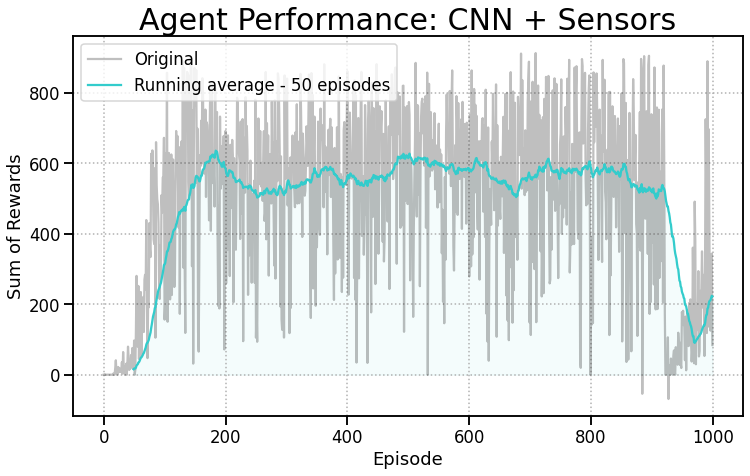

In [6]:
# Plot Results
plot_performance(agent_norris.results, title = 'Agent Performance: CNN + Sensors')

## Test Agent 03: CNN + Sensors

In [9]:
# Set agent to tets
agent = agent_norris
agent.epsilon = 0 # Set epsilon to 0

render = True
seed_nums = [32, 45, 46, 83, 123, 934, 563, 1023, 27546, 32450]
time_steps = 1000

scores = []
env = gym.make('CarRacing-v1', continuous=False)

for e, seed_num in tqdm(enumerate(seed_nums)):
    init_state = env.reset(seed=seed_num)
    init_state = agent.process_state_image(init_state, env)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
    
    for i in range(time_steps):
        
        if render:
            env.render()

        current_state_frame_stack = agent.generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)
        next_state, reward, done, info = env.step(action)

        total_reward += reward

        next_state = agent.process_state_image(next_state, env)
        state_frame_stack_queue.append(next_state)

        if done:
            #print(f'Reward: {round(total_reward,2)}')
            scores.append(round(total_reward,2))
            break

if render:
    env.close()

print(f"Results: {scores}. \n Avg: {np.mean(scores)}")

10it [10:41, 64.11s/it]

Results: [869.49, 565.61, 700.65, 107.27, 890.68, 685.95, 914.0, 587.9, 901.0, 915.8]. 
 Avg: 713.835
